# Project : Predicting Coupon Acceptance on E-commerce Platform

#### Importing Libraries

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, classification_report, recall_score, f1_score, precision_score

#### Loading and previewing the data

In [3]:
df = pd.read_csv('C:/Users/DELL/Downloads/Ds_Data.csv')
print(df.shape)
df.head()

(12684, 25)


,destination,passanger,weather,temperature,coupon,expiration,gender,age,maritalStatus,has_children,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Accept(Y/N?)
0,No Urgent Place,Alone,Sunny,55,Restaurant(<20),1d,Female,21,Unmarried partner,1,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,Coffee House,2h,Female,21,Unmarried partner,1,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,Carry out & Take away,2h,Female,21,Unmarried partner,1,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,Coffee House,2h,Female,21,Unmarried partner,1,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,Coffee House,1d,Female,21,Unmarried partner,1,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [4]:
df.tail()

,destination,passanger,weather,temperature,coupon,expiration,gender,age,maritalStatus,has_children,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Accept(Y/N?)
12679,Home,Partner,Rainy,55,Carry out & Take away,1d,Male,26,Single,0,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,Carry out & Take away,1d,Male,26,Single,0,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,Coffee House,1d,Male,26,Single,0,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,Bar,1d,Male,26,Single,0,...,never,1~3,4~8,1~3,1,1,1,0,1,0
12683,Work,Alone,Sunny,80,Restaurant(20-50),2h,Male,26,Single,0,...,never,1~3,4~8,1~3,1,0,0,1,0,0


In [5]:
# Making a copy of dataset if needed for future use
new_df = df.copy()

## Summary:

This dataset consists of approximately 12684 users, primarily travelers, who are utilizing various types of coupons that are set to expire soon. Among these users, 7,210 accepted new coupons (for renewal) when they were offered, while the remaining 5,474 users declined the coupons.

The survey outlines different driving scenarios, taking into account factors such as the user's destination, current time, weather conditions, number of passengers, coupon attributes, user characteristics, and contextual factors. After reviewing these scenarios, the survey asks users whether they would accept the coupon.

## Objective:

This project aims to use machine learning to analyze driving scenarios and user profiles from an e-commerce website. By predicting coupon acceptance, we can enhance distribution strategies and boost user engagement, ultimately increasing customer satisfaction and sales.

In [6]:
df.dtypes

destination             object
passanger               object
weather                 object
temperature              int64
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
car                     object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Accept(Y/N?)             int64
dtype: object

In [7]:
# Unique values and their counts

for i in df.columns:
    print('********************************',i,'***************************************')
    print(df[i].value_counts())
    print()

******************************** destination ***************************************
destination
No Urgent Place    6283
Home               3237
Work               3164
Name: count, dtype: int64

******************************** passanger ***************************************
passanger
Alone        7305
Friend(s)    3298
Partner      1075
Kid(s)       1006
Name: count, dtype: int64

******************************** weather ***************************************
weather
Sunny    10069
Snowy     1405
Rainy     1210
Name: count, dtype: int64

******************************** temperature ***************************************
temperature
80    6528
55    3840
30    2316
Name: count, dtype: int64

******************************** coupon ***************************************
coupon
Coffee House             3996
Restaurant(<20)          2786
Carry out & Take away    2393
Bar                      2017
Restaurant(20-50)        1492
Name: count, dtype: int64

******************************

### # EDA and Feature Engineering

In [8]:
df['Accept(Y/N?)'].value_counts()   # Checking if the target variable is balanced or not

Accept(Y/N?)
1    7210
0    5474
Name: count, dtype: int64

##### The target variable is balanced

In [9]:
df['toCoupon_GEQ5min'].value_counts() 

toCoupon_GEQ5min
1    12684
Name: count, dtype: int64

#####  Here we observe that there are only 1s and no 0s. No distribution is seen and the column is not providing any valuable information about the data. Hence, we will drop the 'toCoupon_GEQ5min' column.

In [10]:
df.drop('toCoupon_GEQ5min', axis=1, inplace=True)   # Dropping column

In [11]:
df.shape

(12684, 24)

#### Checking for missing values

In [12]:
df.isnull().mean()*100   # Proportion in percentage of missing values

destination              0.000000
passanger                0.000000
weather                  0.000000
temperature              0.000000
coupon                   0.000000
expiration               0.000000
gender                   0.000000
age                      0.000000
maritalStatus            0.000000
has_children             0.000000
education                0.000000
occupation               0.000000
income                   0.000000
car                     99.148534
Bar                      0.843582
CoffeeHouse              1.710817
CarryAway                1.190476
RestaurantLessThan20     1.024913
Restaurant20To50         1.490066
toCoupon_GEQ15min        0.000000
toCoupon_GEQ25min        0.000000
direction_same           0.000000
direction_opp            0.000000
Accept(Y/N?)             0.000000
dtype: float64

### Handling Missing Values

- We are dropping "car" variable since its 99% of the data is missing.

In [13]:
df.drop('car', axis=1, inplace=True)   # Dropping 'Car' variable

In [14]:
df.shape # Checking the shape of data

(12684, 23)

- Imputing Missing Values with its Mode

In [15]:
# Imputing null values with mode

df['Bar'] = df['Bar'].fillna(df['Bar'].mode()[0])
df['CoffeeHouse'] = df['CoffeeHouse'].fillna(df['CoffeeHouse'].mode()[0])
df['RestaurantLessThan20'] = df['RestaurantLessThan20'].fillna(df['RestaurantLessThan20'].mode()[0])
df['Restaurant20To50'] = df['Restaurant20To50'].fillna(df['Restaurant20To50'].mode()[0])
df['CarryAway'] = df['CarryAway'].fillna(df['CarryAway'].mode()[0])

In [16]:
df.isnull().sum()  # Rechecking for Missing Values

destination             0
passanger               0
weather                 0
temperature             0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Accept(Y/N?)            0
dtype: int64

#### Checking for Duplicate values

In [17]:
df.duplicated().sum()

291

In [18]:
df.duplicated().mean()*100

2.294228949858089

##### This means there is only 2% of the data which is duplicate. We can keep the duplicates as it can be handled by algorithms.

In [19]:
# Separating categorical and numeric columns to get clear overview at the features
# Categorical columns

categorical = df.select_dtypes(include='object').columns
categorical

Index(['destination', 'passanger', 'weather', 'coupon', 'expiration', 'gender',
       'age', 'maritalStatus', 'education', 'occupation', 'income', 'Bar',
       'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50'],
      dtype='object')

In [20]:
# Numeric columns

numeric = df.select_dtypes(include='int').columns
numeric

Index(['temperature', 'has_children', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Accept(Y/N?)'],
      dtype='object')

##### Converting the variable 'expiration' into numeric i.e. changing it to hours(time) which will be ideal for modeling

In [21]:
# Checking the value counts before conversion

df['expiration'].value_counts()

expiration
1d    7091
2h    5593
Name: count, dtype: int64

In [22]:
expiration_hours = []

# Looping through the 'expiration' column
for i in df['expiration']:
    if 'd' in i:
        expiration_hours.append(int(i.replace('d', '')) * 24)  # Converts days to hours
    else:
        expiration_hours.append(int(i.replace('h', '')))  # Keeps hours as it is

df['expiration'] = expiration_hours

In [23]:
# Rechecking the values counts after conversion

df['expiration'].value_counts()

expiration
24    7091
2     5593
Name: count, dtype: int64

In [24]:
# Checking value counts of "Direction same" and "Direction opp" variables
print(df['direction_same'].value_counts())
print(df['direction_opp'].value_counts())

direction_same
0    9960
1    2724
Name: count, dtype: int64
direction_opp
1    9960
0    2724
Name: count, dtype: int64


##### Here we observe that, the features - 'direction_same' and 'direction_opp' shows inverse dependency and gives redundant information about the data which leads to Multicollinearity Problem.
##### Hence, we will drop one of the column i.e. 'direction_opp'

In [25]:
# Dropping 'direction_opp'

df.drop(columns=['direction_opp'], inplace=True)

In [26]:
# Rechecking the data
df.head(2)

,destination,passanger,weather,temperature,coupon,expiration,gender,age,maritalStatus,has_children,...,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Accept(Y/N?)
0,No Urgent Place,Alone,Sunny,55,Restaurant(<20),24,Female,21,Unmarried partner,1,...,$37500 - $49999,never,never,1~3,4~8,1~3,0,0,0,1
1,No Urgent Place,Friend(s),Sunny,80,Coffee House,2,Female,21,Unmarried partner,1,...,$37500 - $49999,never,never,1~3,4~8,1~3,0,0,0,0


### Univariate Analysis

##### Let's take a quick glance at the distribution of each categorical feature

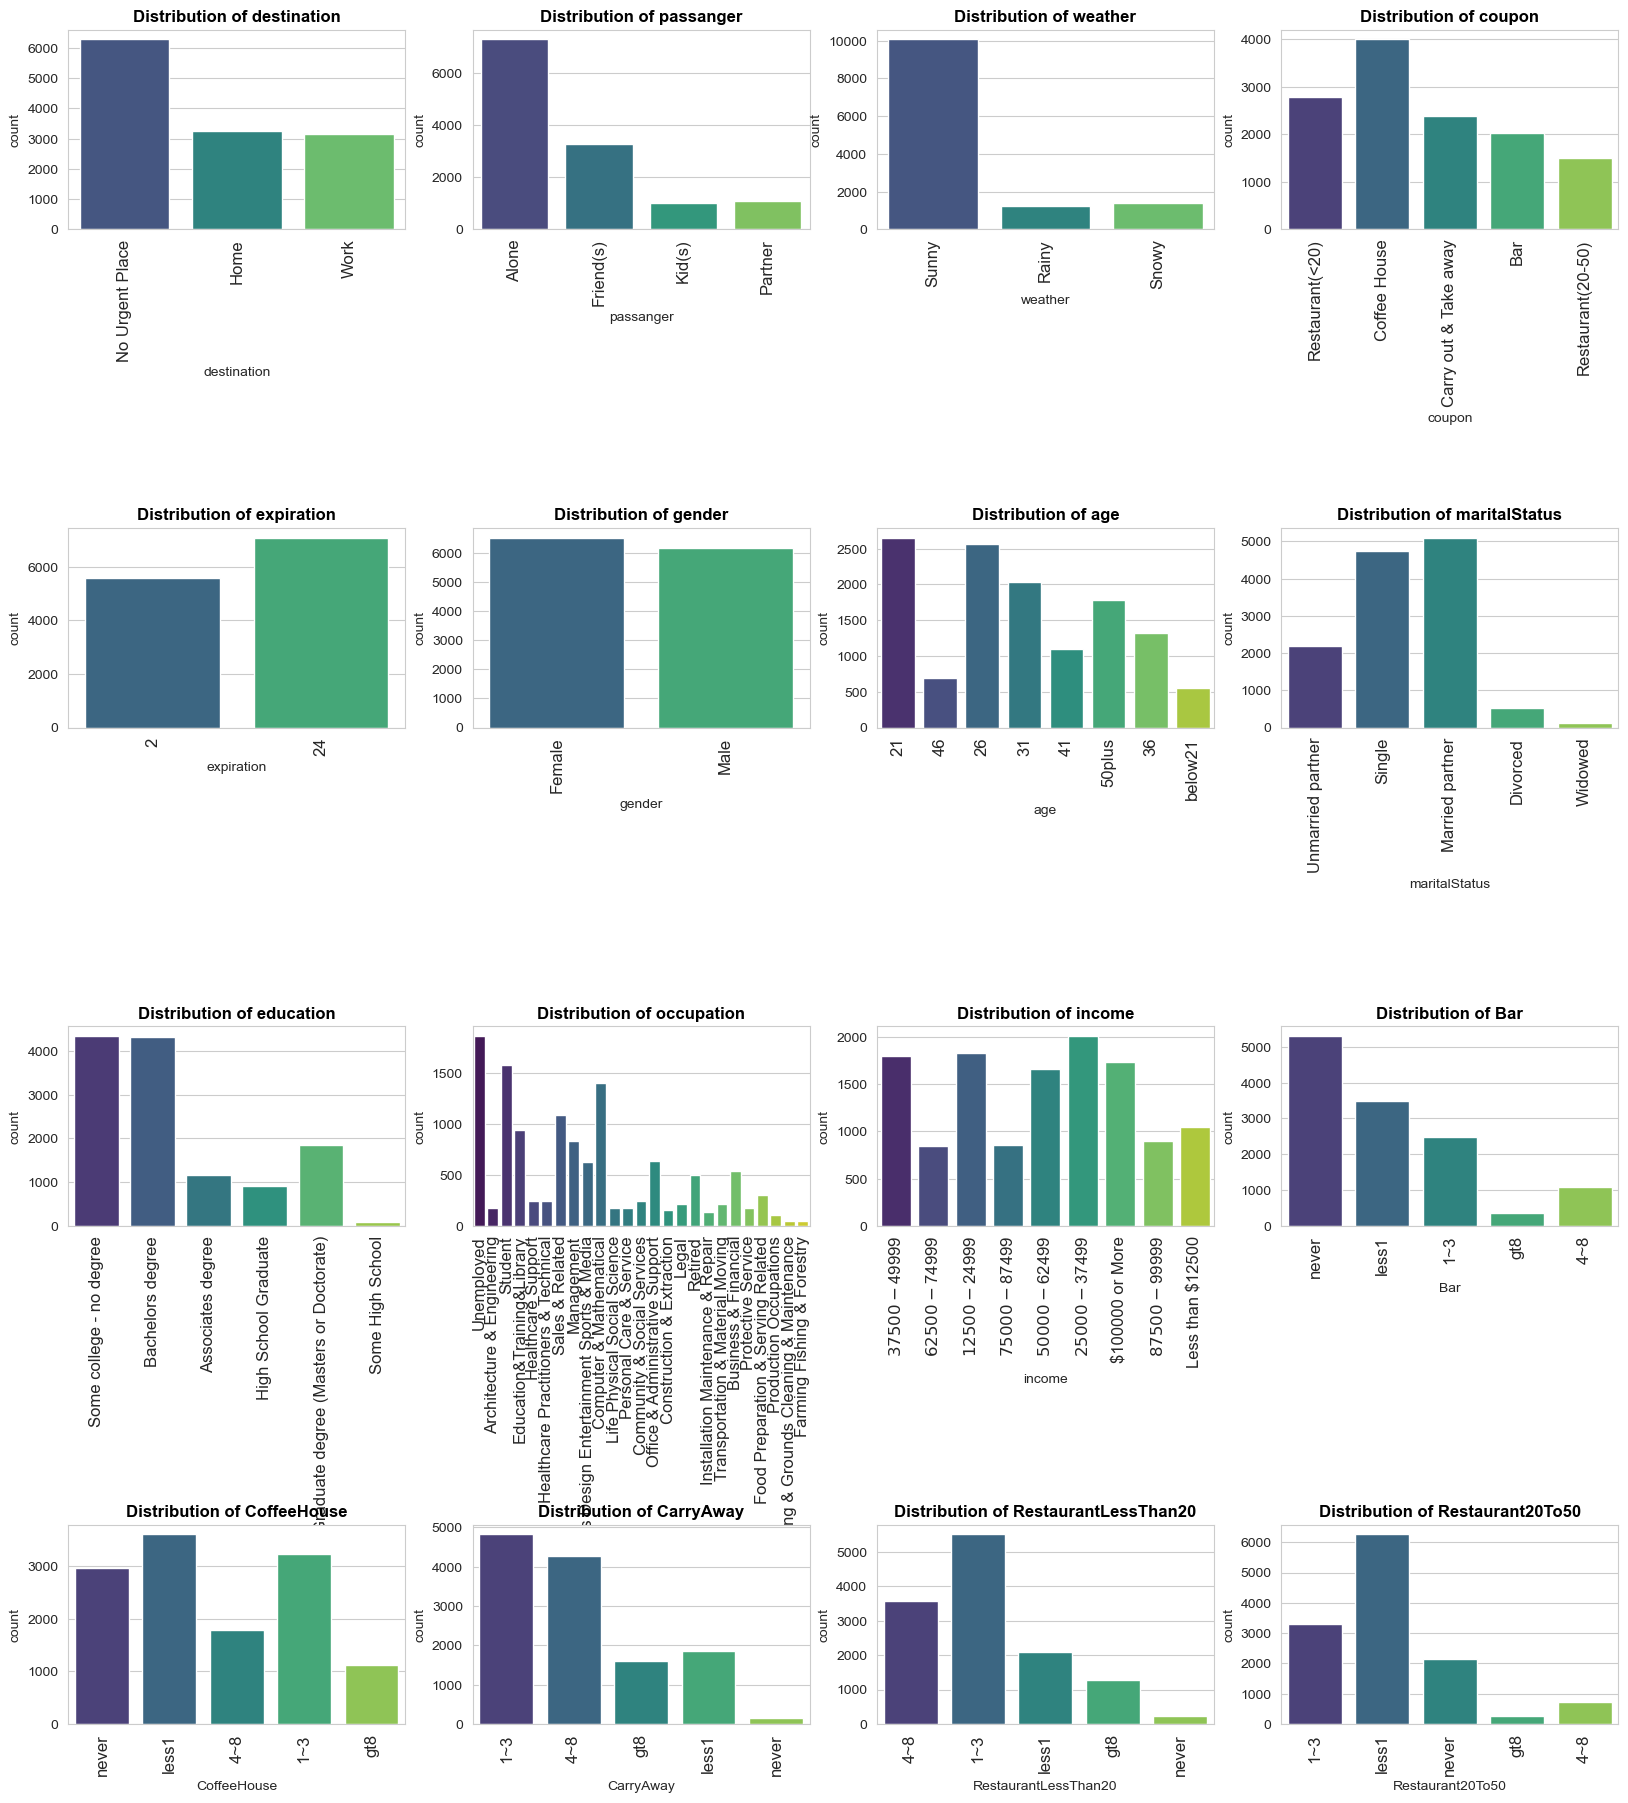

In [27]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,22))
plt.subplots_adjust(hspace=1.5)

for i in range(len(categorical)):
    plt.subplot(4,4, i+1)
    plt.xticks(rotation=90, fontsize=12)
    plt.title(f"Distribution of {categorical[i]}", fontsize=12, fontweight="bold", color="black")
    sns.countplot(x=df[categorical[i]], palette="viridis")

##### Observations:

1. Users aged 21-31 are the highest coupon accepters.
2. People spending <$20 per visit (1-3 or 4-8 times/month) dominate the dataset.
3. People willingly travel 5-25 minutes to redeem coupons.
4. Bars are not popular; very few people visit them.

<Axes: xlabel='coupon', ylabel='count'>

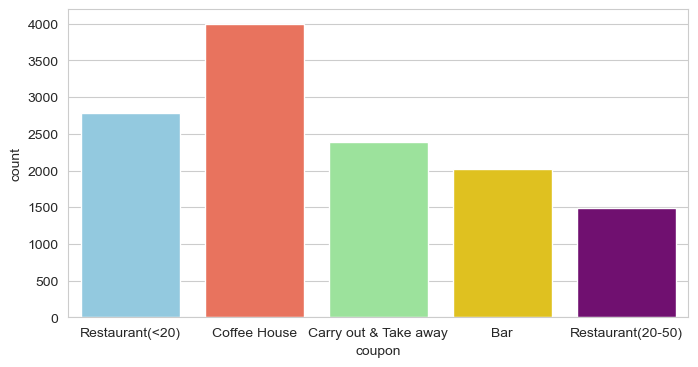

In [47]:
# Distribution of Coupons

colors = ['skyblue','tomato','lightgreen','gold','purple']
plt.figure(figsize=(8,4))
sns.countplot(df, x='coupon', palette=colors)

##### Observation:
- Coupons for "Coffee House" are highest in demand.
- People are also interested in coupons for Restaurant<20 and Take Away.

### Bivariate Analysis

<Axes: xlabel='direction_same', ylabel='count'>

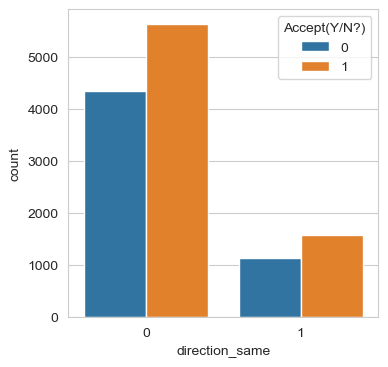

In [29]:
# Analysing relationship between Users Accepting/Declining Coupons and The Direction same and their Current Location

plt.figure(figsize=(4,4))
sns.countplot(df, x = df['direction_same'], hue=df['Accept(Y/N?)'])

##### Observation:
- 78% accept coupons even if the place is in the opposite direction.

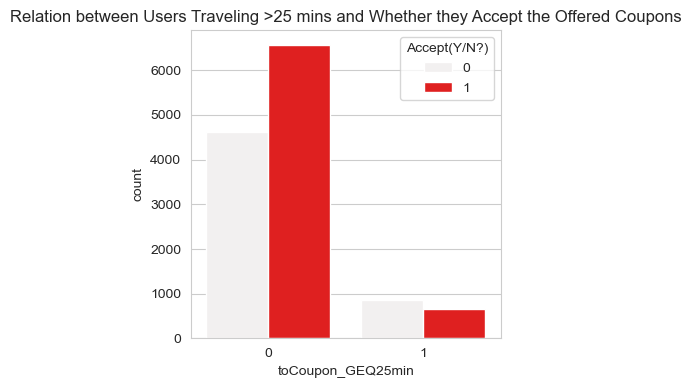

In [58]:
plt.figure(figsize=(4,4))
plot = sns.countplot(df, x = df['toCoupon_GEQ25min'], hue=df['Accept(Y/N?)'], color='r')
plt.title('Relation between Users Traveling >25 mins and Whether they Accept the Offered Coupons')
plt.show()

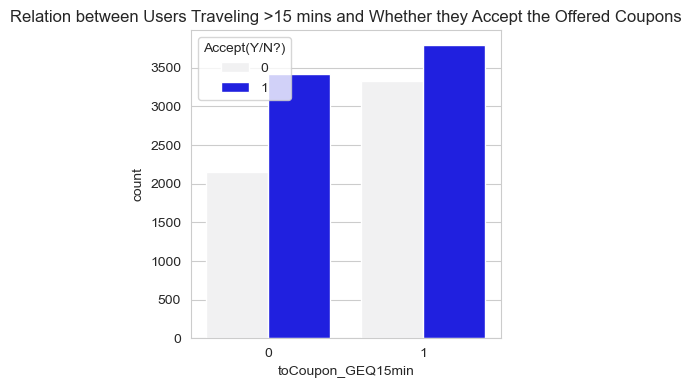

In [57]:
plt.figure(figsize=(4,4))
plot = sns.countplot(df, x = df['toCoupon_GEQ15min'], hue=df['Accept(Y/N?)'], color='b')
plt.title('Relation between Users Traveling >15 mins and Whether they Accept the Offered Coupons')
plt.show()

##### Observations:
- People willingly travel 5-25 minutes to redeem coupons.

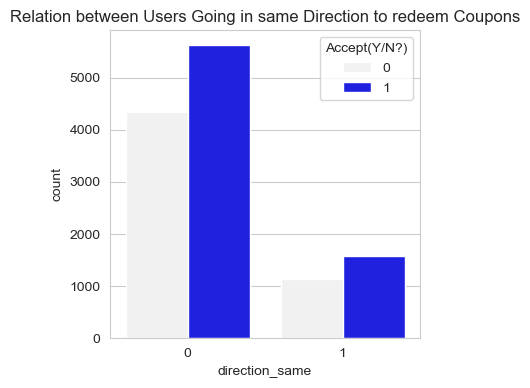

In [59]:
plt.figure(figsize=(4,4))
plot = sns.countplot(df, x = df['direction_same'], hue=df['Accept(Y/N?)'], color='b')
plt.title('Relation between Users Going in same Direction to redeem Coupons')
plt.show()

##### Observation:
- 78% accept coupons even if the place is in the opposite direction.

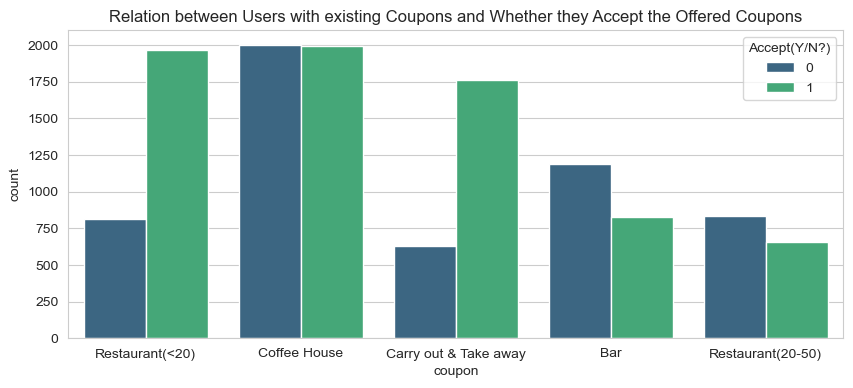

In [30]:
# Analysing relationship between Users Accepting/Declining Coupons with the Type of Coupons they have

plt.figure(figsize=(10,4))
plot = sns.countplot(df, x = df['coupon'], hue=df['Accept(Y/N?)'], palette='viridis')
plt.title('Relation between Users with existing Coupons and Whether they Accept the Offered Coupons')
plt.show()

##### Observations:
- 1. Takeaways & restaurant (<20) coupons are accepted the most.
- 2. Coffee house coupon acceptance is 50-50, likely due to small discounts and minimal bill difference.
- 3. Users spending 20-50 dollars don't accept coupons much, possibly due to affordability.
- 4. More people are rejecting Bar coupons.

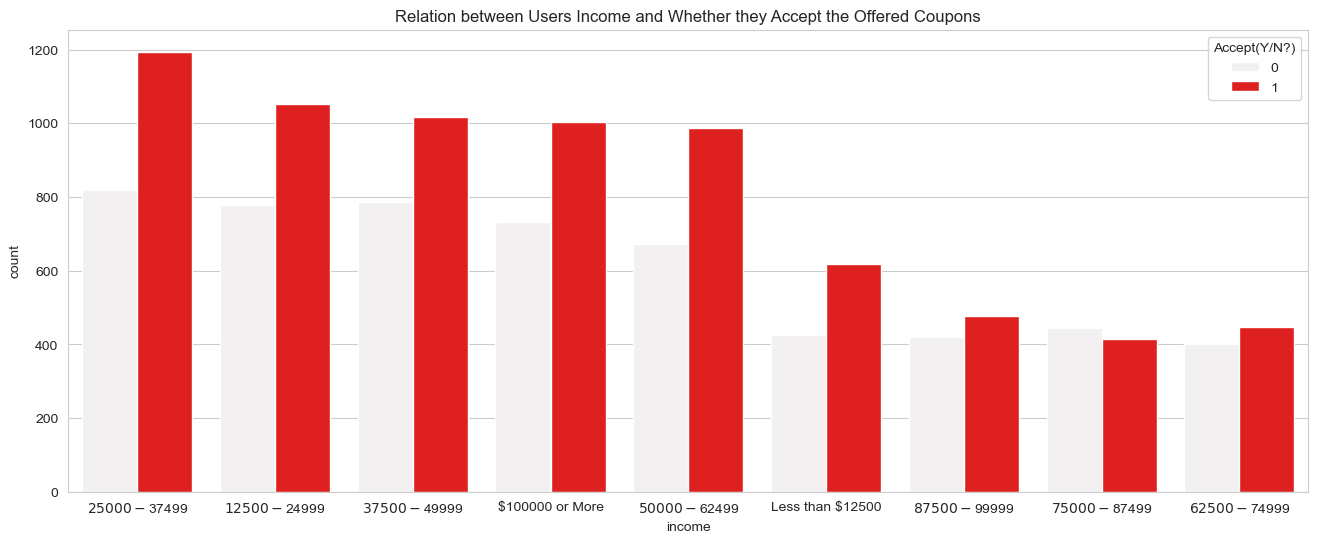

In [60]:
# Analysing relationship between Users Accepting/Declining Coupons And thier Income

sorted_order = df['income'].value_counts().index
plt.figure(figsize=(16,6))
plot = sns.countplot(df, x = df['income'], hue=df['Accept(Y/N?)'], color='r', order=sorted_order)
plt.title('Relation between Users Income and Whether they Accept the Offered Coupons')
plt.show()

##### Observation:
- Top coupon accepters earn between 12,500 - 62,500, while some high earners (100k+) also accept coupons.

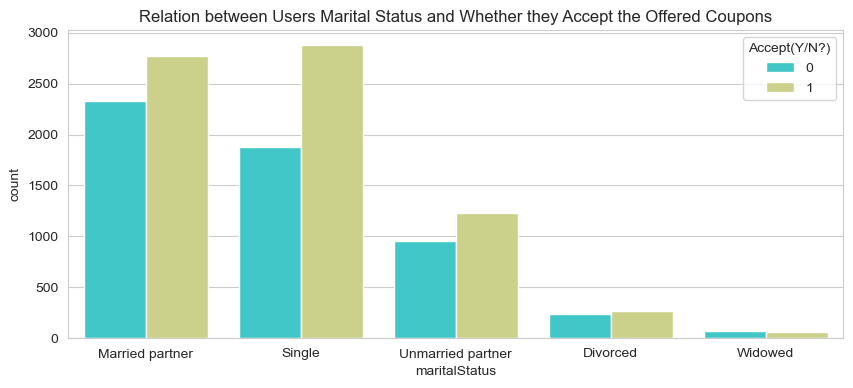

In [61]:
# Analysing relationship between Users Accepting/Declining Coupons AND their Marital Status
sorted_order = df['maritalStatus'].value_counts().index
plt.figure(figsize=(10,4))
plot = sns.countplot(df, x = df['maritalStatus'], hue=df['Accept(Y/N?)'], palette='rainbow', order=sorted_order)
plt.title('Relation between Users Marital Status and Whether they Accept the Offered Coupons')
plt.show()

##### Observation:
- Single & Married individuals accept coupons the most.

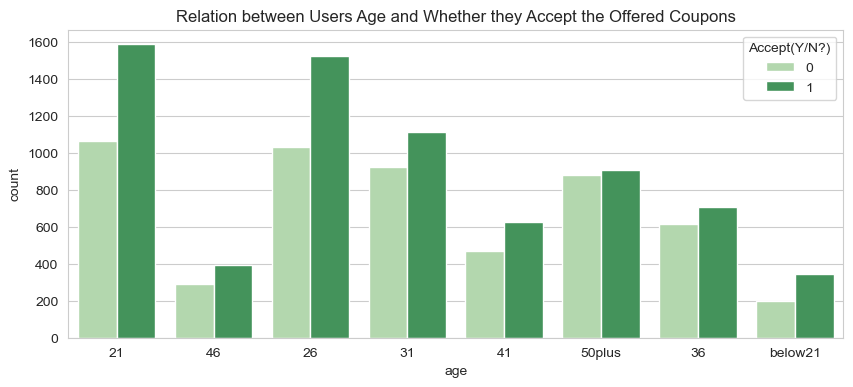

In [62]:
# Analysing relationship between Users Accepting/Declining Coupons AND their Age

plt.figure(figsize=(10,4))
plot = sns.countplot(df, x = df['age'], hue=df['Accept(Y/N?)'], palette='Greens')
plt.title('Relation between Users Age and Whether they Accept the Offered Coupons')
plt.show()

##### Here we observe,
- Young people i.e. between age 21 to 31 are accepting coupons the most as compared to older ones i.e. between 36 to 41
- Assuming that People between 21 to 46 are earning and below 21 being unemployed

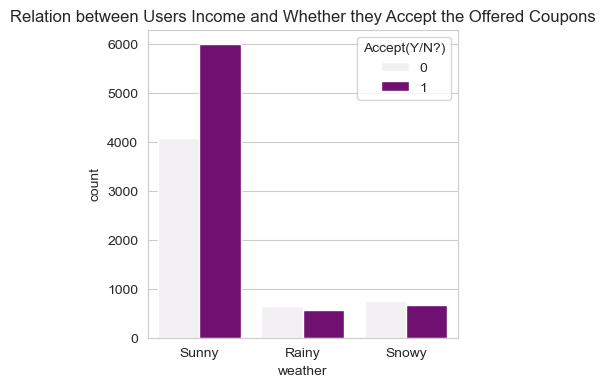

In [63]:
# Analysing relationship between Users Accepting/Declining Coupons AND the Weather

plt.figure(figsize=(4,4))
plot = sns.countplot(df, x = df['weather'], hue=df['Accept(Y/N?)'], color='purple')
plt.title('Relation between Users Income and Whether they Accept the Offered Coupons')
plt.show()

##### Observation:
- Coupons are accepted more on sunny days, very few on rainy/snowy days.

<Axes: xlabel='gender', ylabel='count'>

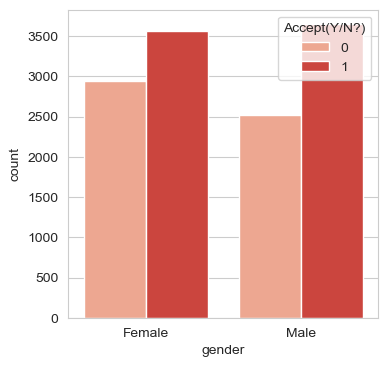

In [64]:
plt.figure(figsize=(4,4))
sns.countplot(data=df, x=df['gender'], hue=df['Accept(Y/N?)'], palette='Reds')

##### Observation:
- Equal number of Males and Females accepts the coupons offered
- Whereas, more number of Females Declines coupons as compared to Males

In [66]:
numeric = df.select_dtypes(include='int').columns
numeric

Index(['temperature', 'expiration', 'has_children', 'toCoupon_GEQ15min',
       'toCoupon_GEQ25min', 'direction_same', 'Accept(Y/N?)'],
      dtype='object')

##### Checking Correlation between Numeric features

In [67]:
numeric_df = df.select_dtypes(include=['number'])  # Selecting only numeric columns
corr_matrix = numeric_df.corr()  # Calculating correlation matrix
corr_matrix

,temperature,expiration,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Accept(Y/N?)
temperature,1.000000,-0.124090,-0.019716,-0.155332,-0.216254,0.097085,0.061240
expiration,-0.124090,1.000000,-0.016020,-0.042740,0.032977,-0.033584,0.129920
has_children,-0.019716,-0.016020,1.000000,0.078211,-0.013722,-0.031620,-0.045557
toCoupon_GEQ15min,-0.155332,-0.042740,0.078211,1.000000,0.324984,-0.303533,-0.081602
toCoupon_GEQ25min,-0.216254,0.032977,-0.013722,0.324984,1.000000,-0.192319,-0.103633
direction_same,0.097085,-0.033584,-0.031620,-0.303533,-0.192319,1.000000,0.014570
Accept(Y/N?),0.061240,0.129920,-0.045557,-0.081602,-0.103633,0.014570,1.000000


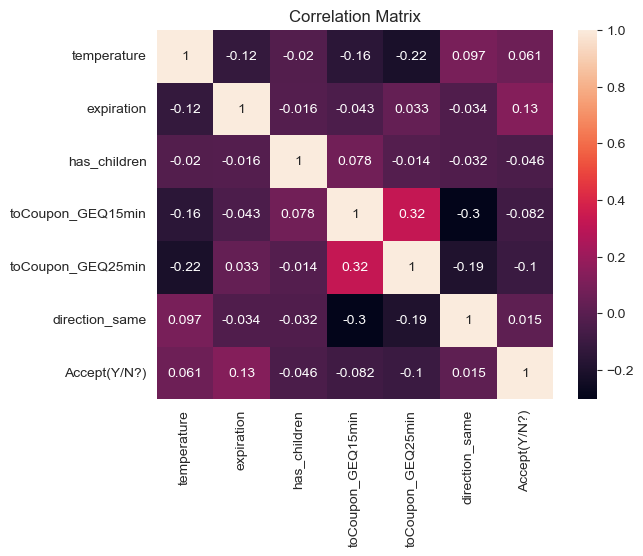

In [68]:
# Plotting Heatmap

sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

### # Data Preprocessing

#### Splitting the data into X and Y

In [69]:
df.shape

(12684, 22)

In [70]:
x = df.drop(columns=['Accept(Y/N?)'])
y = df['Accept(Y/N?)']

In [71]:
print(x.shape)
print(y.shape)

(12684, 21)
(12684,)


#### Splitting the data into Train and Test

In [72]:
# Splitting the data into training and test ( Choosing 80-20)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [73]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(10147, 21)
(2537, 21)
(10147,)
(2537,)


### Encoding categorical variables

In [74]:
categorical

Index(['destination', 'passanger', 'weather', 'coupon', 'expiration', 'gender',
       'age', 'maritalStatus', 'education', 'occupation', 'income', 'Bar',
       'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50'],
      dtype='object')

##### Sorting the categorical variables in Nominal and Ordinal

- Nominal(No specific order) One Hot Encoding:
destination, passanger, weather, coupon, gender, maritalStatus, occupation(too many cat)

- Ordinal(Order) *Ordinal Encoding:
age, education, income, bar, CoffeeHouse, CarryAway, 'RestaurantLessThan20, Restaurant20To50

In [75]:
# For Ordinal Encoding
# Storing categories of each feature in a list

age_order = ['below21', '21', '26', '31', '36', '41', '46', '50plus']

education_order = ['Some High School', 'High School Graduate', 'Some college - no degree', 'Associates degree',
                   'Bachelors degree', 'Graduate degree (Masters or Doctorate)']

income_order = ['Less than $12500', '$12500 - $24999', '$25000 - $37499', '$37500 - $49999', '$50000 - $62499',
                '$62500 - $74999', '$75000 - $87499', '$87500 - $99999', '$100000 or More']

frequency_order = ['never', 'less1', '1~3', '4~8', 'gt8']


# Creating Column Transformer - to encode and scale
transformer = ColumnTransformer(transformers=[
    ('Ordinal', OrdinalEncoder(categories=[age_order, education_order, income_order, frequency_order, frequency_order, 
                                           frequency_order, frequency_order, frequency_order]),
     ['age', 'education', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']),
    
    ('OHE', OneHotEncoder(handle_unknown='ignore', sparse= False),
    ['destination', 'passanger', 'weather', 'coupon', 'gender', 'maritalStatus', 'occupation']),
    
    ('scaler', StandardScaler(), ['temperature', 'expiration'])
], remainder='passthrough')

In [76]:
# Fit and transform on training data
x_train_transformed = transformer.fit_transform(x_train)

# Transform on test data 
x_test_transformed = transformer.transform(x_test)

In [77]:
x_train_transformed.shape

(10147, 61)

In [78]:
x_test_transformed.shape

(2537, 61)

In [79]:
x_train_df = pd.DataFrame(x_train_transformed, columns= transformer.get_feature_names_out())
x_test_df = pd.DataFrame(x_test_transformed, columns= transformer.get_feature_names_out())

## Model Training

### Logistic Regression

In [80]:
# Model Training
LR = LogisticRegression()
LR.fit(x_train_transformed,y_train)


# Prediction
LR_y_train_pred = LR.predict(x_train_transformed)   # Predicting Train Data
LR_y_test_pred  = LR.predict(x_test_transformed)    # Predicting Test Data


# Accuracy

LR_train_accuracy = accuracy_score(LR_y_train_pred, y_train)  # Train Accuracy
LR_test_accuracy = accuracy_score(LR_y_test_pred, y_test)     # Test Accuracy

print(f'Logistic Regression Train Accuracy: {LR_train_accuracy:.4f}')
print(f'Logistic Regression Test Accuracy: {LR_test_accuracy:.4f}')

Logistic Regression Train Accuracy: 0.6860
Logistic Regression Test Accuracy: 0.6768


In [81]:
# Classification Report
LR_report = classification_report(LR_y_test_pred, y_test, zero_division=0)
print(LR_report)

              precision    recall  f1-score   support

           0       0.55      0.66      0.60       938
           1       0.78      0.68      0.73      1599

    accuracy                           0.68      2537
   macro avg       0.66      0.67      0.67      2537
weighted avg       0.69      0.68      0.68      2537



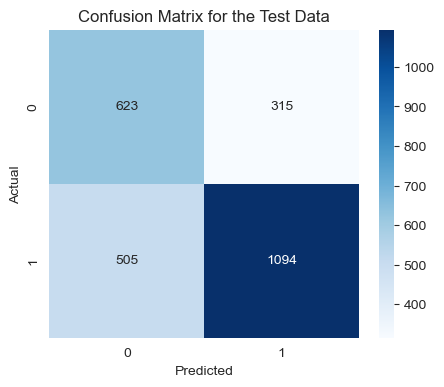

In [82]:
cm_test = confusion_matrix(LR_y_test_pred, y_test)

plt.figure(figsize=(5,4))
sns.heatmap(cm_test, fmt = 'd', annot=True, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for the Test Data')
plt.show()

### XGBoost Classifier

In [83]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model on the transformed training data
xgb.fit(x_train_transformed, y_train)

# Predict on the training and test sets
y_train_pred = xgb.predict(x_train_transformed)
y_test_pred = xgb.predict(x_test_transformed)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"XGBoost Train Accuracy: {train_accuracy:.3f}")
print(f"XGBoost Test Accuracy: {test_accuracy:.3f}")
print("Classification Report:\n", classification_report(y_test, y_test_pred))

XGBoost Train Accuracy: 0.899
XGBoost Test Accuracy: 0.745
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.66      0.70      1128
           1       0.75      0.81      0.78      1409

    accuracy                           0.75      2537
   macro avg       0.74      0.74      0.74      2537
weighted avg       0.74      0.75      0.74      2537



### Decision Tree Classifier

In [84]:
# Training model
dt = DecisionTreeClassifier(max_depth=10,random_state=42)
dt.fit(x_train_transformed,y_train)


# Prediction
dt_train_pred = dt.predict(x_train_transformed)
dt_test_pred = dt.predict(x_test_transformed)

# Accuracy
dt_train_accuracy = accuracy_score(dt_train_pred, y_train)
dt_test_accuracy = accuracy_score(dt_test_pred, y_test)

print(f'Decision Tree Train Accuracy: {dt_train_accuracy:.3f}')
print(f'Decision Tree Test Accuracy: {dt_test_accuracy:.3f}')

Decision Tree Train Accuracy: 0.788
Decision Tree Test Accuracy: 0.690


### Random Forest Classifier

In [86]:
# Importing GridSearchCV

from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state = 40)
param_dict = {'max_depth':[6,8],
              'max_features': ['auto', 'log2'],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(rf, cv = 10,param_grid = param_dict, n_jobs=3)

cv_rf.fit(x_train_transformed, y_train)    #Training data

print(f'Best parameter using Grid Search CV : {cv_rf.best_params_}')
print(f'Best score using Grid Search CV : {cv_rf.best_score_}')

Best parameter using Grid Search CV : {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto'}
Best score using Grid Search CV : 0.7184404543290486


Text(0.5, 1.0, 'OOB Error Rate across various forest sizes')

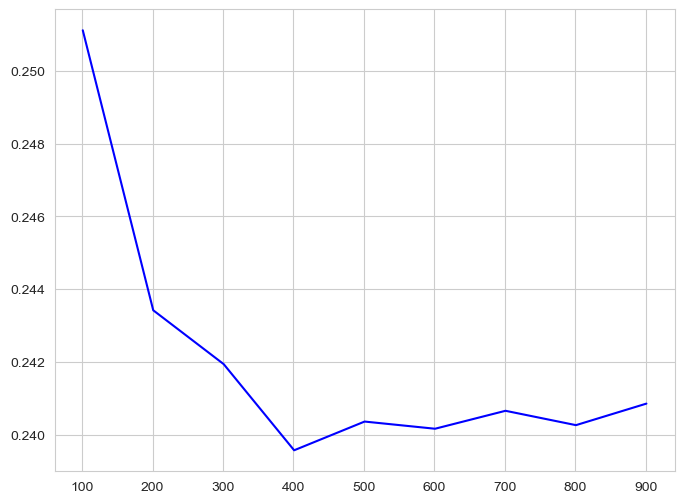

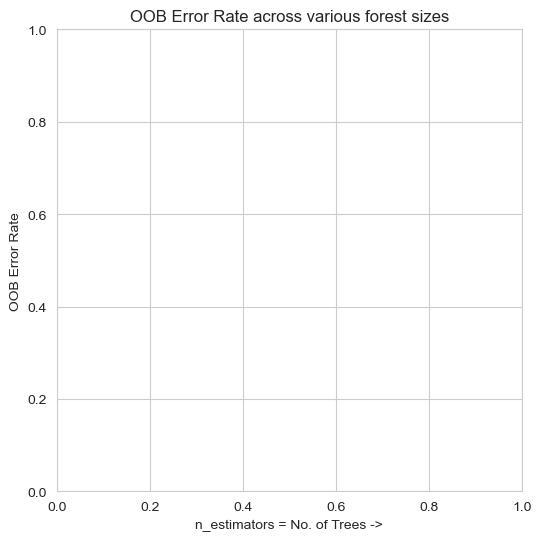

In [87]:
step_size = 100
min_estimators = 100
max_estimators= 1000

error_rate = {}
rf = RandomForestClassifier(n_estimators=i, oob_score=True, random_state=40, warm_start=False)

for i in range(min_estimators +1, max_estimators + 1, step_size):
    
    rf.set_params(n_estimators = i)
    rf.fit(x_train_transformed, y_train)
    
    oob_error = 1 - rf.oob_score_
    error_rate[i] = oob_error
    
oob_series = pd.Series(error_rate)

fig, ax = plt.subplots(figsize=(8,6))

oob_series.plot(kind='line', color = 'blue')
plt.figure(figsize=(6,6))
plt.xlabel('n_estimators = No. of Trees ->')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate across various forest sizes')

In [88]:
rf.set_params(n_estimators = 600, bootstrap=True, criterion= 'gini', max_depth= 6, max_features = 'auto', warm_start = False, oob_score = False)

RandomForestClassifier(max_depth=6, max_features='auto', n_estimators=600,
                       random_state=40)

In [89]:
rf.fit(x_train_transformed, y_train)  # Training set

RandomForestClassifier(max_depth=6, max_features='auto', n_estimators=600,
                       random_state=40)

In [90]:
rf_train_accuracy = rf.score(x_train_transformed, y_train)
rf_test_accuracy = rf.score(x_test_transformed, y_test)

print(f'Training score: {train_accuracy}')
print(f'Test score: {test_accuracy}')

Training score: 0.8986892677638711
Test score: 0.745368545526212


### Hyperparameter Tuning of Models to solve Over fitting

In [91]:
# Hyperparameter-tuned models
RF = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
DT = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
xgb_model_2 = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss')

# Train and evaluate
models = {"Random Forest": RF, "Decision Tree": DT, "XGBoost": xgb_model_2}
for name, model in models.items():
    model.fit(x_train_transformed, y_train)
    y_train_pred = model.predict(x_train_transformed)
    y_test_pred = model.predict(x_test_transformed)
    print(f"{name} - Train Accuracy: {accuracy_score(y_train, y_train_pred):.3f}")
    print(f"{name} - Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}\n")

Random Forest - Train Accuracy: 0.774
Random Forest - Test Accuracy: 0.717

Decision Tree - Train Accuracy: 0.775
Decision Tree - Test Accuracy: 0.686

XGBoost - Train Accuracy: 0.827
XGBoost - Test Accuracy: 0.743



In [92]:
# Precision

precision = precision_score(y_test, y_test_pred)
print(f'Precision score: {precision}')

# Accuracy score

accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy score: {accuracy}')

# Recall

recall = recall_score(y_test, y_test_pred)
print(f'Recall score: {recall}')

# F1 score

f1 = f1_score(y_test, y_test_pred)
print(f'F1 score: {f1}')

Precision score: 0.74185303514377
Accuracy score: 0.7430035474970438
Recall score: 0.8239886444286728
F1 score: 0.7807666442501682


In [94]:
# Predicting probability

y_test_prob = RF.predict_proba(x_test_transformed)[:,1]
print(y_test_prob)

# Probabilities of FPR, TPR and different thresholds of ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

auc = roc_auc_score(y_test,y_test_prob)

[0.53888901 0.67287893 0.25336028 ... 0.75610299 0.75852707 0.63008865]


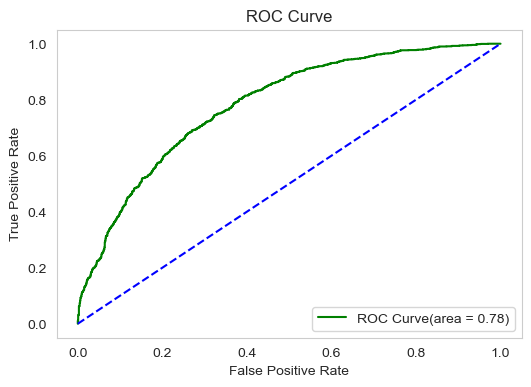

In [95]:
# Plotting ROC Curve

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='green', label = f'ROC Curve(area = {auc:.2f})')
plt.plot([0,1], [0,1], color= 'blue', linestyle= '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

### Feature Importance

In [99]:
# Getting feature names
features = x_train.columns 

# Creating an empty dictionary to store important features
important_features = {}

for feature in features:
    total = 0
    for i, j in zip(features, RF.feature_importances_):
        if feature in i:
            total += j
    important_features[feature] = total

# Convert to DataFrame
feature_importance_df = pd.DataFrame(list(important_features.items()), columns=['Feature', 'Importance'])

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                 Feature  Importance
4                 coupon    0.091953
19     toCoupon_GEQ25min    0.080666
18     toCoupon_GEQ15min    0.047867
3            temperature    0.045788
20        direction_same    0.040857
2                weather    0.035893
0            destination    0.034666
9           has_children    0.032309
1              passanger    0.028123
7                    age    0.027143
12                income    0.024782
5             expiration    0.024614
17      Restaurant20To50    0.021749
6                 gender    0.019952
8          maritalStatus    0.015655
10             education    0.013987
11            occupation    0.013784
13                   Bar    0.011479
16  RestaurantLessThan20    0.011398
15             CarryAway    0.009924
14           CoffeeHouse    0.005294


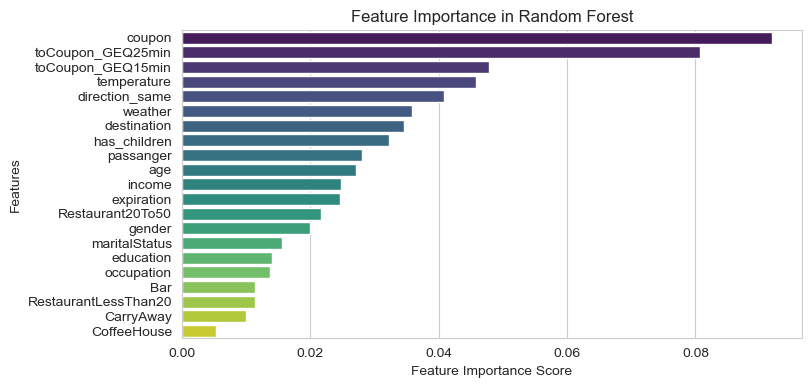

In [100]:
plt.figure(figsize=(8, 4))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette='viridis')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.show()

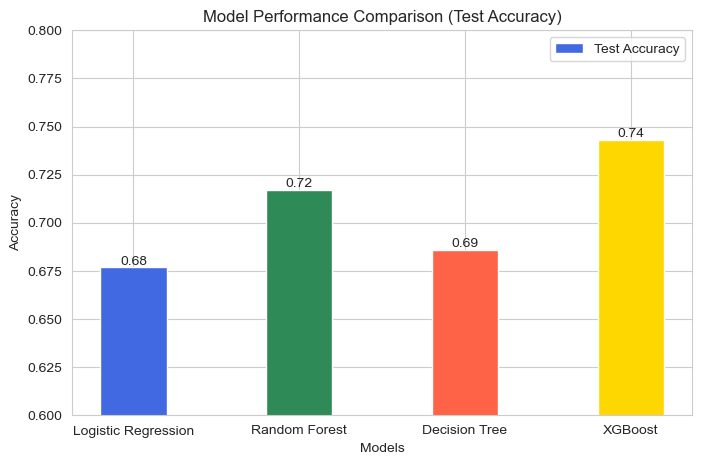

In [101]:
# Model names and their accuracies
models = ["Logistic Regression", "Random Forest", "Decision Tree", "XGBoost"]
train_accuracies = [0.6860, 0.774, 0.775, 0.827]
test_accuracies = [0.6768, 0.717, 0.686, 0.743]

x = np.arange(len(models))  # Label locations
width = 0.4  # Bar width

fig, ax = plt.subplots(figsize=(8, 5))

colors = ['royalblue', 'seagreen', 'tomato', 'gold']
# Plot bars
bars_test = ax.bar(x, test_accuracies, width, label="Test Accuracy", color=colors)

# Annotate bars with accuracy values
for bar in bars_test:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Labels and title
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")
ax.set_title("Model Performance Comparison (Test Accuracy)")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.ylim(0.6, 0.80)  # Set y-axis limits for better visualization

# Show the plot
plt.show()


## Conclusion:
##### XGBoost performed the best with a test accuracy of 74.3%, making it the most effective model for predicting coupon acceptance.
##### Random Forest followed closely behind with a test accuracy of 71.7%, showing strong performance as well.
##### These two models outperformed Decision Tree (68.6%) and Logistic Regression (67.7%), which had lower accuracy.

## Model Performance Summary:

We tested different machine learning models to predict whether users would accept coupons. After tuning the models to reduce overfitting, here’s what we found:

- Logistic Regression performed the weakest, with a test accuracy of 67.68% and moderate precision and recall.
- Decision Tree overfitted the data, doing well on training 77.5% but dropping to 68.6% on the test set, meaning it didn’t generalize well.
- Random Forest improved on this, reaching 71.7% test accuracy after tuning, making it more reliable.
- XGBoost gave the best results, with a 74.3% test accuracy and a high recall of 82.3%, meaning it was the most effective in identifying users likely to accept coupons.

Looking at feature importance, coupon type, travel time to the coupon, and temperature had the biggest impact on a user’s decision.

We also plotted the ROC curve to compare models, which confirmed that XGBoost was the most balanced and effective model.

## Actions and Recommendations:

1. Improve coffee house coupons by increasing discount value or adding special offers.
2. Target 21-31 age group & single/married users with personalized deals.
3. Focus on customers spending <20 dollars per visit, as they respond well to coupons.
4. Promote takeaways & low-cost restaurants, as they are the most preferred.
5. Consider location-based targeting, since many users accept coupons for places in the opposite direction.
6. Optimize coupon validity (5-25 min travel time), as people are willing to go that far.
7. Reduce coupon offers for bars, as they have the least impact.
8. Re-evaluate $20-$50 spending group, since they don’t seem to need coupons.
9. Offer exclusive deals for high earners ($100k+), as they surprisingly accept coupons.
10. Increase coupon promotions on sunny days, as people go out more.